In [1]:
import torch
import os
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
# Load CSV files
train_data = pd.read_csv('train_data.csv')
superclass_map = pd.read_csv('superclass_mapping.csv')
subclass_map = pd.read_csv('subclass_mapping.csv')

train_img_dir = 'train_shuffle'

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        superclass_label = self.dataframe.iloc[idx, 1]
        subclass_label = self.dataframe.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        return image, superclass_label, subclass_label

class CustomTestImageDataset(Dataset):
    def __init__(self, super_map_df, sub_map_df, img_dir, transform=None):
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        # print(f"Trying to open image at path: {img_path}")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Image transformations with advanced augmentations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset and DataLoader
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

validation_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)


train_dataset = CustomDataset(dataframe=train_df, root_dir=train_img_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

validation_dataset = CustomDataset(dataframe=validation_df, root_dir=train_img_dir, transform=transform)
validation_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = CustomDataset(dataframe=test_df, root_dir=train_img_dir, transform=transform)
test_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [3]:
class HierarchicalConvNeXt(nn.Module):
    def __init__(self, base_model, num_superclasses, num_subclasses):
        super(HierarchicalConvNeXt, self).__init__()
        # Copy all layers except the classifier from the base model
        self.features = base_model.features
        self.avgpool = base_model.avgpool

        # Determine the number of in-features for the new classifier layers
        # It should be the same as the in_features of the last Linear layer in the original classifier
        in_features = base_model.classifier[2].in_features

        # Create new classifier layers for super-classes and sub-classes
        self.fc_super = nn.Linear(in_features, num_superclasses)
        self.fc_sub = nn.Linear(in_features, num_subclasses)

    def forward(self, x):
        # Pass input through the feature extractor and the avgpool layer
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten the features into a single vector per image

        # Pass the flattened features through the new classifier layers
        superclass_logits = self.fc_super(x)
        subclass_logits = self.fc_sub(x)
        return superclass_logits, subclass_logits

In [4]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_correct_super, total_correct_sub, total_samples = 0, 0, 0
    total_val_loss_super, total_val_loss_sub = 0, 0

    with torch.no_grad():
        for images, superclass_labels, subclass_labels in validation_loader:
            images = images.to(device)
            superclass_labels = superclass_labels.to(device)
            subclass_labels = subclass_labels.to(device)

            superclass_logits, subclass_logits = model(images)
            _, superclass_preds = torch.max(superclass_logits, 1)
            _, subclass_preds = torch.max(subclass_logits, 1)

            loss_super = criterion(superclass_logits, superclass_labels)
            loss_sub = criterion(subclass_logits, subclass_labels)

            total_val_loss_super += loss_super.item()
            total_val_loss_sub += loss_sub.item()

            total_correct_super += (superclass_preds == superclass_labels).sum().item()
            total_correct_sub += (subclass_preds == subclass_labels).sum().item()
            total_samples += images.size(0)

    return total_correct_super/total_samples, total_correct_sub/total_samples, total_val_loss_super/len(train_loader), total_val_loss_sub/len(train_loader)

In [5]:
def compute_f1(model, test_loader, device):
    model.eval()
    super_true, sub_true = [], []
    super_pred, sub_pred = [], []
    with torch.no_grad():
        for images, superclass_labels, subclass_labels in test_loader:
            images = images.to(device)
            superclass_labels = superclass_labels.to(device)
            subclass_labels = subclass_labels.to(device)
            super_true.append(superclass_labels.item())
            sub_true.append(subclass_labels.item())

            super_outputs, sub_outputs = model(images)
            _, super_predicted = torch.max(super_outputs.data, 1)
            _, sub_predicted = torch.max(sub_outputs.data, 1)

            super_pred.append(super_predicted.item())
            sub_pred.append(sub_predicted.item())
    return f1_score(super_true,super_pred,average='micro'), f1_score(sub_true,sub_pred,average='micro')

In [6]:
device = torch.device('mps')
base_model = models.convnext_large(pretrained=True)
model = HierarchicalConvNeXt(base_model, num_superclasses=len(superclass_map), num_subclasses=len(subclass_map)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

/Users/ryan_huang/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ryan_huang/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Early stopping setup
early_stopping_patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')

num_epochs = 20
train_losses_super, train_losses_sub = [], []
train_correct_super, train_correct_sub = [], []
val_losses_super, val_losses_sub = [], []
val_correct_super, val_correct_sub = [], []


for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss, total_train_loss_super, total_train_loss_sub = 0, 0, 0
    total_train_correct_super, total_train_correct_sub, total_samples = 0, 0, 0


    for images, superclass_labels, subclass_labels in train_loader:
        images, superclass_labels, subclass_labels = images.to(device), superclass_labels.to(device), subclass_labels.to(device)

        optimizer.zero_grad()
        superclass_logits, subclass_logits = model(images)

        _, superclass_preds = torch.max(superclass_logits, 1)
        _, subclass_preds = torch.max(subclass_logits, 1)
        total_train_correct_super += (superclass_preds == superclass_labels).sum().item()
        total_train_correct_sub += (subclass_preds == subclass_labels).sum().item()
        total_samples += images.size(0)
        
        loss_super = criterion(superclass_logits, superclass_labels)
        loss_sub = criterion(subclass_logits, subclass_labels)
        loss = loss_super + loss_sub
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_loss_super += loss_super.item()
        total_train_loss_sub += loss_sub.item()
    
    # Calculate average loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses_super.append(total_train_loss_super / len(train_loader))
    train_losses_sub.append(total_train_loss_sub / len(train_loader))
    train_correct_super.append(total_train_correct_super / total_samples)
    train_correct_sub.append(total_train_correct_sub / total_samples)

    # Evaluate the model on the val set
    superclass_accuracy, subclass_accuracy, val_loss_super, val_loss_sub = evaluate_model(model, validation_loader, device)
    val_losses_super.append(val_loss_super)
    val_losses_sub.append(val_loss_sub)
    val_correct_super.append(superclass_accuracy)
    val_correct_sub.append(subclass_accuracy)

    
    
    print(f'Epoch {epoch+1}, Avg Train Loss: {avg_train_loss:.4f}, Superclass Accuracy: {superclass_accuracy:.4f}, Subclass Accuracy: {subclass_accuracy:.4f}')

    # Early stopping check
    if val_loss_super + val_loss_sub < best_val_loss:
        best_val_loss = val_loss_super + val_loss_sub
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'model_state_dict.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Epoch 1, Avg Train Loss: 3.5615, Superclass Accuracy: 0.8297, Subclass Accuracy: 0.3686
Epoch 2, Avg Train Loss: 2.8722, Superclass Accuracy: 0.8467, Subclass Accuracy: 0.4137
Epoch 3, Avg Train Loss: 2.5394, Superclass Accuracy: 0.8932, Subclass Accuracy: 0.4291
Epoch 4, Avg Train Loss: 2.5104, Superclass Accuracy: 0.8916, Subclass Accuracy: 0.4967
Epoch 5, Avg Train Loss: 2.4771, Superclass Accuracy: 0.9033, Subclass Accuracy: 0.5003
Epoch 6, Avg Train Loss: 2.2442, Superclass Accuracy: 0.9126, Subclass Accuracy: 0.4981
Epoch 7, Avg Train Loss: 2.1275, Superclass Accuracy: 0.9098, Subclass Accuracy: 0.5752
Epoch 8, Avg Train Loss: 2.1128, Superclass Accuracy: 0.9031, Subclass Accuracy: 0.5482
Epoch 9, Avg Train Loss: 2.1760, Superclass Accuracy: 0.8772, Subclass Accuracy: 0.6033
Epoch 10, Avg Train Loss: 1.9027, Superclass Accuracy: 0.9413, Subclass Accuracy: 0.6456
Epoch 11, Avg Train Loss: 1.8089, Superclass Accuracy: 0.9373, Subclass Accuracy: 0.6172
Epoch 12, Avg Train Loss: 1.68

In [8]:
torch.save(model.state_dict(), 'model_state_dict.pth')

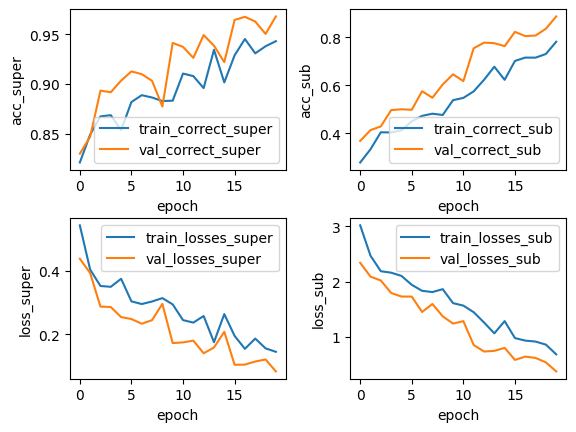

In [9]:
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(2,2,1)
plt.plot(range(len(train_correct_super)),train_correct_super,label='train_correct_super')
plt.plot(range(len(val_correct_super)),val_correct_super,label='val_correct_super')
plt.xlabel('epoch')
plt.ylabel('acc_super')
plt.legend()


plt.subplot(2,2,2)
plt.plot(range(len(train_correct_sub)),train_correct_sub,label='train_correct_sub')
plt.plot(range(len(val_correct_sub)),val_correct_sub,label='val_correct_sub')
plt.xlabel('epoch')
plt.ylabel('acc_sub')
plt.legend()

plt.subplot(2,2,3)
plt.plot(range(len(train_losses_super)),train_losses_super,label='train_losses_super')
plt.plot(range(len(val_losses_super)),val_losses_super,label='val_losses_super')
plt.xlabel('epoch')
plt.ylabel('loss_super')
plt.legend()

plt.subplot(2,2,4)
plt.plot(range(len(train_losses_sub)),train_losses_sub,label='train_losses_sub')
plt.plot(range(len(val_losses_sub)),val_losses_sub,label='val_losses_sub')
plt.xlabel('epoch')
plt.ylabel('loss_sub')
plt.legend()

plt.savefig('connext.png', dpi=1000)
plt.show()

In [10]:
model = HierarchicalConvNeXt(base_model, num_superclasses=len(superclass_map), num_subclasses=len(subclass_map))
model.load_state_dict(torch.load('model_state_dict.pth'))
model.to(device)

HierarchicalConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          

In [11]:
# Generate Predictions
superclass_f1_score, subclass_f1_score = compute_f1(model, test_loader, device)
print('Superclass_f1_score:', superclass_f1_score)
print('Subclass_f1_score:', subclass_f1_score)

Superclass_f1_score: 0.9679651967569706
Subclass_f1_score: 0.8860984773581173
